# Evaluation of XGBoost GEDI -> S1S2 Regression Model

Having successfully ingested GEDI L4A and collocated Sentinel statistical data into a spatiotemporal database, energies now focussed on training a random model regressor to predict wall-to-wall maps of GEDI-estimated Aboveground Biomass Density. Using the functional firepower of PostgreSQL and PostGIS, aggregated subsets of collocated GEDI and Sentinel-based metrics were extracted from the spatiotemporal database as a source of training and test data. 

__Important Note:__ Statistics related to [S2 cloudless mask](https://docs.sentinel-hub.com/api/latest/user-guides/cloud-masks/) were retrieved from Sentinel-Hub and ingested into the Sentinel-2 data tables - records were therefore filtered based on presence of cloud contamination affecting multispectral statistic calculations.

### Load and filter GEDI + Sentinel SAR and multispectral metrics from CSV file

In [1]:
import pandas as pd

# load sql dump dataset
df = pd.read_csv("result_update.csv" )
df.columns

Index(['shot_number', 'datetime', 'ndvi_mean', 'ndvi_stdev', 'evi_mean',
       'evi_stdev', 'gndvi_mean', 'gndvi_stdev', 'ndci_mean', 'ndci_stdev',
       'mcari_mean', 'mcari_stdev', 'lai_mean', 'lai_stdev', 'fapar_mean',
       'fapar_stdev', 'fcover_mean', 'fcover_stdev', 'ccc_mean', 'ccc_stdev',
       'cab_mean', 'cab_stdev', 'vv_mean', 'vv_stdev', 'vh_mean', 'vh_stdev',
       'rvi_mean', 'rvi_stdev', 'atsavi_mean', 'atsavi_stdev', 'avi_mean',
       'avi_stdev', 'bwdrvi_mean', 'bwdrvi_stdev', 'cari_mean', 'cari_stdev',
       'ctvi_mean', 'ctvi_stdev', 'gemi_mean', 'gemi_stdev', 'lci_mean',
       'lci_stdev', 'mcari_osavi_mean', 'mcari_osavi_stdev', 'msavi_mean',
       'msavi_stdev', 'mtvi2_mean', 'mtvi2_stdev', 'pndvi_mean', 'pndvi_stdev',
       'pvi_mean', 'pvi_stdev', 'rsr_stdev', 'reip1_mean', 'reip1_stdev',
       'sarvi_mean', 'sarvi_stdev', 'savi_mean', 'savi_stdev', 'nsimss_mean',
       'nsimss_stdev', 'gvi_mean', 'gvi_stdev', 'tcari_mean', 'tcari_stdev',
       'tn

In [2]:
# filter out high value agbd outliers
names = [ col for col in df.columns if 'stdev' in col or 'mean' in col ]
names.extend( [ 'agbd', 'solar_elevation', 'doy', 'landsat_treecover', 'geometry' ] )

df = df[ names ]
df = df[ ~df.isnull().any(axis=1)]
df = df[ df[ 'agbd'] < 200  ]

df.head(5)

,ndvi_mean,ndvi_stdev,evi_mean,evi_stdev,gndvi_mean,gndvi_stdev,ndci_mean,ndci_stdev,mcari_mean,mcari_stdev,...,tsavi_stdev,tci_mean,tci_stdev,varirededge_mean,varirededge_stdev,agbd,solar_elevation,doy,landsat_treecover,geometry
0,0.291376,0.015606,0.165770,0.011002,0.388302,0.010073,0.131362,0.011447,0.029094,0.004091,...,146.695745,0.028822,0.003819,0.131362,0.011447,6.651023,19.975058,71,9,0101000020E61000001B4F7A0C351E4240A6D2EED47210...
1,0.269227,0.034365,0.148565,0.021000,0.427946,0.024159,0.117192,0.018679,0.022538,0.006509,...,141.338519,0.019826,0.006483,0.117192,0.018679,31.625132,20.010387,71,6,0101000020E6100000F7CBAF6E00224240CC5EE0839A69...
3,0.640556,0.070545,0.419729,0.071231,0.606387,0.053391,0.300911,0.058271,0.079783,0.024884,...,5.818297,0.066356,0.015647,0.300911,0.058271,115.615028,20.518637,71,27,0101000020E61000003A6B52EFBA584240919BF11206EB...
4,0.579399,0.094203,0.404494,0.094958,0.570705,0.054946,0.259774,0.071382,0.076620,0.031332,...,53.658756,0.064929,0.021825,0.259774,0.071382,12.274698,20.539778,71,16,0101000020E6100000913A1449035B4240562C3DD68352...
5,0.748194,0.021236,0.367423,0.073883,0.644166,0.020502,0.369602,0.051228,0.066766,0.022553,...,0.631956,0.055309,0.015035,0.369602,0.051228,92.346329,40.693127,253,51,0101000020E6100000D414A6FA9B9A42404E5B88DE1004...


### Transpose into GeoDataFrame in preparation for spatial aggregation

In [3]:
import geopandas as gpd
from shapely import wkb

# convert wkb geometries into shapely point objects in geographic crs
df['geometry'] = df['geometry'].apply( wkb.loads, hex=True )
gdf = gpd.GeoDataFrame( df, geometry='geometry', crs='epsg:4326' )

In [4]:
gdf.total_bounds, len( gdf )

(array([35.41428939, -1.30904186, 37.39445352,  0.86672992]), 339958)

In [5]:
# subset - optional - and reproject to pseudo mercator
gdf = gdf.cx[ 36:37, -1.0:0.0 ]
gdf = gdf.to_crs( 3857 )
gdf

,ndvi_mean,ndvi_stdev,evi_mean,evi_stdev,gndvi_mean,gndvi_stdev,ndci_mean,ndci_stdev,mcari_mean,mcari_stdev,...,tsavi_stdev,tci_mean,tci_stdev,varirededge_mean,varirededge_stdev,agbd,solar_elevation,doy,landsat_treecover,geometry
0,0.291376,0.015606,0.165770,0.011002,0.388302,0.010073,0.131362,0.011447,0.029094,0.004091,...,146.695745,0.028822,0.003819,0.131362,0.011447,6.651023,19.975058,71,9,POINT (4033772.391 -59362.853)
1,0.269227,0.034365,0.148565,0.021000,0.427946,0.024159,0.117192,0.018679,0.022538,0.006509,...,141.338519,0.019826,0.006483,0.117192,0.018679,31.625132,20.010387,71,6,POINT (4037072.377 -64053.317)
7,0.379653,0.058794,0.221880,0.040194,0.417894,0.044949,0.154614,0.038600,0.036796,0.013031,...,35.591905,0.037394,0.010657,0.154614,0.038600,11.673766,20.304173,71,5,POINT (4064490.074 -103985.182)
30,0.788133,0.020070,0.480243,0.059454,0.687058,0.022770,0.433297,0.035950,0.107504,0.019621,...,1.142851,0.078344,0.009795,0.433297,0.035950,154.413666,25.718346,264,97,POINT (4093609.089 -36238.190)
31,0.655264,0.040018,0.510728,0.066379,0.575506,0.038635,0.306674,0.043683,0.090812,0.018714,...,14.080380,0.078782,0.013114,0.306674,0.043683,31.730585,25.736086,264,51,POINT (4091866.293 -39798.893)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365558,0.650011,0.022023,0.431122,0.030298,0.566782,0.014173,0.348334,0.026474,0.114107,0.015943,...,88.787328,0.092864,0.009581,0.348334,0.026474,9.906432,-66.151558,182,6,POINT (4059720.897 -23006.950)
365559,0.744767,0.088508,0.548300,0.125300,0.667886,0.049077,0.425615,0.098950,0.178538,0.082165,...,43.602517,0.120695,0.038389,0.425615,0.098950,10.606074,-66.047020,182,16,POINT (4066658.161 -13140.661)
365560,0.786000,0.016111,0.456203,0.038255,0.676739,0.017522,0.439879,0.025886,0.110545,0.015392,...,0.329519,0.080529,0.008001,0.439879,0.025886,126.382660,-66.021164,182,90,POINT (4068374.252 -10701.657)
365562,0.649938,0.044124,0.470920,0.051203,0.562877,0.029201,0.319895,0.043381,0.099366,0.020672,...,18.023661,0.087420,0.013332,0.319895,0.043381,10.447485,-8.085246,197,12,POINT (4075498.847 -79029.986)


<AxesSubplot:ylabel='Frequency'>

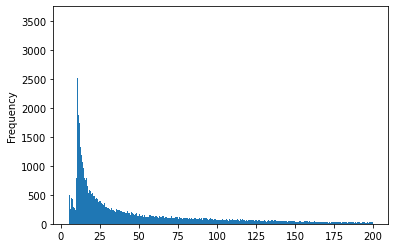

In [6]:
# plot agbd distribution
gdf[ 'agbd' ].plot.hist(bins=1000)

### Generate regular grid encapsulating extent of GEDI / Sentinel sample data

In [7]:
# total area for the grid
xmin, ymin, xmax, ymax= gdf.total_bounds
gdf.total_bounds

array([ 4.00750185e+06, -1.11324885e+05,  4.11881951e+06, -3.55920011e-01])

In [8]:
import numpy as np
import shapely

cell_size = 1000

# generate grid of nominated cell size in metres
cells = []
for x0 in np.arange( xmin, xmax+cell_size, cell_size ):
    for y0 in np.arange( ymin, ymax+cell_size, cell_size):
        
        # bounds
        x1 = x0-cell_size
        y1 = y0+cell_size
        
        cells.append( shapely.geometry.box(x0, y0, x1, y1) )        

In [9]:
# create dataframe comprising grid cell polygons
grid = gpd.GeoDataFrame( cells, crs='epsg:3857', columns=['geometry'] )
grid.head(5)

,geometry
0,"POLYGON ((4006501.849 -111324.885, 4006501.849..."
1,"POLYGON ((4006501.849 -110324.885, 4006501.849..."
2,"POLYGON ((4006501.849 -109324.885, 4006501.849..."
3,"POLYGON ((4006501.849 -108324.885, 4006501.849..."
4,"POLYGON ((4006501.849 -107324.885, 4006501.849..."


### Visualise grid superimposed over colour-coded GEDI-based AGBD estimates

(-57824.88541858853, -51824.88541858853)

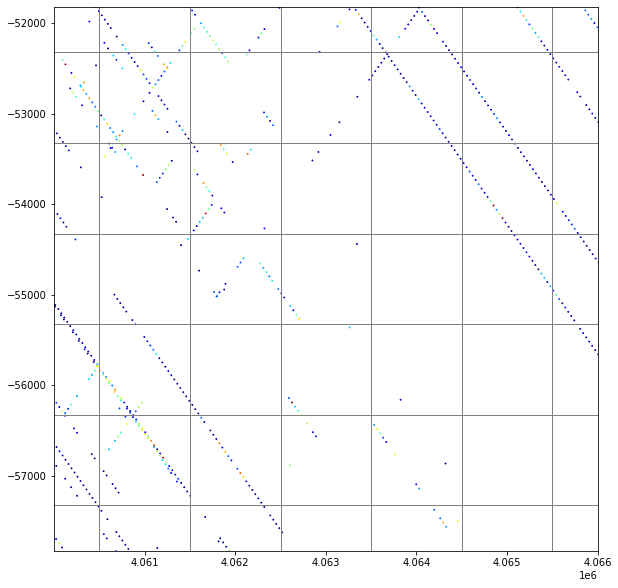

In [10]:
import matplotlib.pyplot as plt

# plot points overlaid by grid
ax = gdf.plot(markersize=.8, figsize=(20, 10), column='agbd', cmap='jet')
plt.autoscale(False)
grid.plot(ax=ax, aspect=1, facecolor="none", edgecolor='grey')

xc, yc = grid.dissolve().centroid.x.values[0], grid.dissolve().centroid.y.values[0]

plt.xlim( [ xc - 3000, xc + 3000 ] )
plt.ylim( [ yc - 3000, yc + 3000 ] )

### Compute spatially aggregated GEDI-Sentinel parameter values within each grid cell 

In [11]:
# merge dataframes to assign GEDI-Sentinel point geometries to corresponding grid cell
merge = gpd.sjoin( gdf, grid, how='left', predicate='within' )
merge.head(5)

,ndvi_mean,ndvi_stdev,evi_mean,evi_stdev,gndvi_mean,gndvi_stdev,ndci_mean,ndci_stdev,mcari_mean,mcari_stdev,...,tci_mean,tci_stdev,varirededge_mean,varirededge_stdev,agbd,solar_elevation,doy,landsat_treecover,geometry,index_right
0,0.291376,0.015606,0.165770,0.011002,0.388302,0.010073,0.131362,0.011447,0.029094,0.004091,...,0.028822,0.003819,0.131362,0.011447,6.651023,19.975058,71,9,POINT (4033772.391 -59362.853),3102.0
1,0.269227,0.034365,0.148565,0.021000,0.427946,0.024159,0.117192,0.018679,0.022538,0.006509,...,0.019826,0.006483,0.117192,0.018679,31.625132,20.010387,71,6,POINT (4037072.377 -64053.317),3437.0
7,0.379653,0.058794,0.221880,0.040194,0.417894,0.044949,0.154614,0.038600,0.036796,0.013031,...,0.037394,0.010657,0.154614,0.038600,11.673766,20.304173,71,5,POINT (4064490.074 -103985.182),6448.0
30,0.788133,0.020070,0.480243,0.059454,0.687058,0.022770,0.433297,0.035950,0.107504,0.019621,...,0.078344,0.009795,0.433297,0.035950,154.413666,25.718346,264,97,POINT (4093609.089 -36238.190),9906.0
31,0.655264,0.040018,0.510728,0.066379,0.575506,0.038635,0.306674,0.043683,0.090812,0.018714,...,0.078782,0.013114,0.306674,0.043683,31.730585,25.736086,264,51,POINT (4091866.293 -39798.893),9676.0


In [12]:
# compute median GEDI-Sentinel point by dissolving on spatial join index
agg = merge.dissolve(by="index_right", aggfunc='median')
agg.head(5)

,geometry,ndvi_mean,ndvi_stdev,evi_mean,evi_stdev,gndvi_mean,gndvi_stdev,ndci_mean,ndci_stdev,mcari_mean,...,tsavi_mean,tsavi_stdev,tci_mean,tci_stdev,varirededge_mean,varirededge_stdev,agbd,solar_elevation,doy,landsat_treecover
index_right,,,,,,,,,,,,,,,,,,,,,
149.0,"MULTIPOINT (4007527.658 -74359.168, 4007560.67...",0.653781,0.050974,0.511954,0.070145,0.600002,0.029820,0.310053,0.050608,0.109701,...,-14.539609,131.587017,0.091117,0.016903,0.310053,0.050608,10.365868,14.262178,135.0,19.0
150.0,"MULTIPOINT (4007631.235 -73803.402, 4007642.89...",0.412857,0.053095,0.245082,0.040993,0.489377,0.032863,0.164664,0.042645,0.035739,...,5.578556,44.623287,0.034320,0.011540,0.164664,0.042645,11.120900,69.646904,125.0,22.5
152.0,"MULTIPOINT (4008229.268 -72082.599, 4008275.53...",0.538207,0.081438,0.252474,0.067000,0.539025,0.040751,0.254991,0.068396,0.049678,...,3.565211,4.391437,0.042414,0.016084,0.254991,0.068396,9.164226,67.952782,240.0,20.0
153.0,"MULTIPOINT (4007516.214 -71174.230, 4007995.95...",0.504221,0.064161,0.264248,0.043860,0.547301,0.034380,0.209771,0.045209,0.043497,...,5.913767,12.247159,0.038958,0.011370,0.209771,0.045209,11.422557,-26.013619,79.0,16.0
154.0,"MULTIPOINT (4007560.852 -70099.123, 4007594.22...",0.560844,0.067549,0.308647,0.059176,0.575276,0.037940,0.245378,0.057474,0.054355,...,6.215316,13.471739,0.047034,0.014148,0.245378,0.057474,10.481143,-26.013314,79.0,16.0


In [13]:
# compute number of GEDI-Sentinel points per grid cell by dissolving on spatial join index
count = merge.dissolve( by="index_right", aggfunc='count')
count.head(5)

,geometry,ndvi_mean,ndvi_stdev,evi_mean,evi_stdev,gndvi_mean,gndvi_stdev,ndci_mean,ndci_stdev,mcari_mean,...,tsavi_mean,tsavi_stdev,tci_mean,tci_stdev,varirededge_mean,varirededge_stdev,agbd,solar_elevation,doy,landsat_treecover
index_right,,,,,,,,,,,,,,,,,,,,,
149.0,"MULTIPOINT (4007527.658 -74359.168, 4007560.67...",10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10
150.0,"MULTIPOINT (4007631.235 -73803.402, 4007642.89...",18,18,18,18,18,18,18,18,18,...,18,18,18,18,18,18,18,18,18,18
152.0,"MULTIPOINT (4008229.268 -72082.599, 4008275.53...",5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
153.0,"MULTIPOINT (4007516.214 -71174.230, 4007995.95...",8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,8
154.0,"MULTIPOINT (4007560.852 -70099.123, 4007594.22...",12,12,12,12,12,12,12,12,12,...,12,12,12,12,12,12,12,12,12,12


In [14]:
# combine median + count spatial aggregations
data = agg.copy().reset_index( drop=True).copy()
data[ 'count'] = count[ 'agbd' ].values 

# apply minimum count condition to sample data
data = data[ data[ 'count'] > 2 ].drop( [ 'count', 'geometry' ], axis=1 )
data

,ndvi_mean,ndvi_stdev,evi_mean,evi_stdev,gndvi_mean,gndvi_stdev,ndci_mean,ndci_stdev,mcari_mean,mcari_stdev,...,tsavi_mean,tsavi_stdev,tci_mean,tci_stdev,varirededge_mean,varirededge_stdev,agbd,solar_elevation,doy,landsat_treecover
0,0.653781,0.050974,0.511954,0.070145,0.600002,0.029820,0.310053,0.050608,0.109701,0.026049,...,-14.539609,131.587017,0.091117,0.016903,0.310053,0.050608,10.365868,14.262178,135.0,19.0
1,0.412857,0.053095,0.245082,0.040993,0.489377,0.032863,0.164664,0.042645,0.035739,0.013383,...,5.578556,44.623287,0.034320,0.011540,0.164664,0.042645,11.120900,69.646904,125.0,22.5
2,0.538207,0.081438,0.252474,0.067000,0.539025,0.040751,0.254991,0.068396,0.049678,0.023493,...,3.565211,4.391437,0.042414,0.016084,0.254991,0.068396,9.164226,67.952782,240.0,20.0
3,0.504221,0.064161,0.264248,0.043860,0.547301,0.034380,0.209771,0.045209,0.043497,0.014623,...,5.913767,12.247159,0.038958,0.011370,0.209771,0.045209,11.422557,-26.013619,79.0,16.0
4,0.560844,0.067549,0.308647,0.059176,0.575276,0.037940,0.245378,0.057474,0.054355,0.020260,...,6.215316,13.471739,0.047034,0.014148,0.245378,0.057474,10.481143,-26.013314,79.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8043,0.614321,0.049962,0.494256,0.041462,0.518082,0.037365,0.305665,0.054035,0.109322,0.026789,...,-23.352199,206.625984,0.097370,0.015865,0.305665,0.054035,20.830180,-41.798105,313.0,20.0
8045,0.757151,0.037490,0.515485,0.050174,0.646461,0.025868,0.415859,0.051029,0.130291,0.027273,...,5.858422,20.980366,0.099331,0.013997,0.415859,0.051029,19.232078,-41.806307,313.0,35.5
8046,0.593145,0.074381,0.473935,0.086556,0.538128,0.042066,0.265602,0.058946,0.081966,0.031477,...,-0.327174,32.507783,0.074621,0.021980,0.265602,0.058946,19.706699,-41.810928,313.0,12.0
8053,0.527634,0.082115,0.317582,0.061817,0.549847,0.050530,0.228533,0.073050,0.057750,0.025547,...,-1.865762,67.666892,0.049941,0.018073,0.228533,0.073050,22.566043,31.160867,8.0,9.0


### Visualise collinearity between spatially aggregated GEDI / Sentinel parameter values

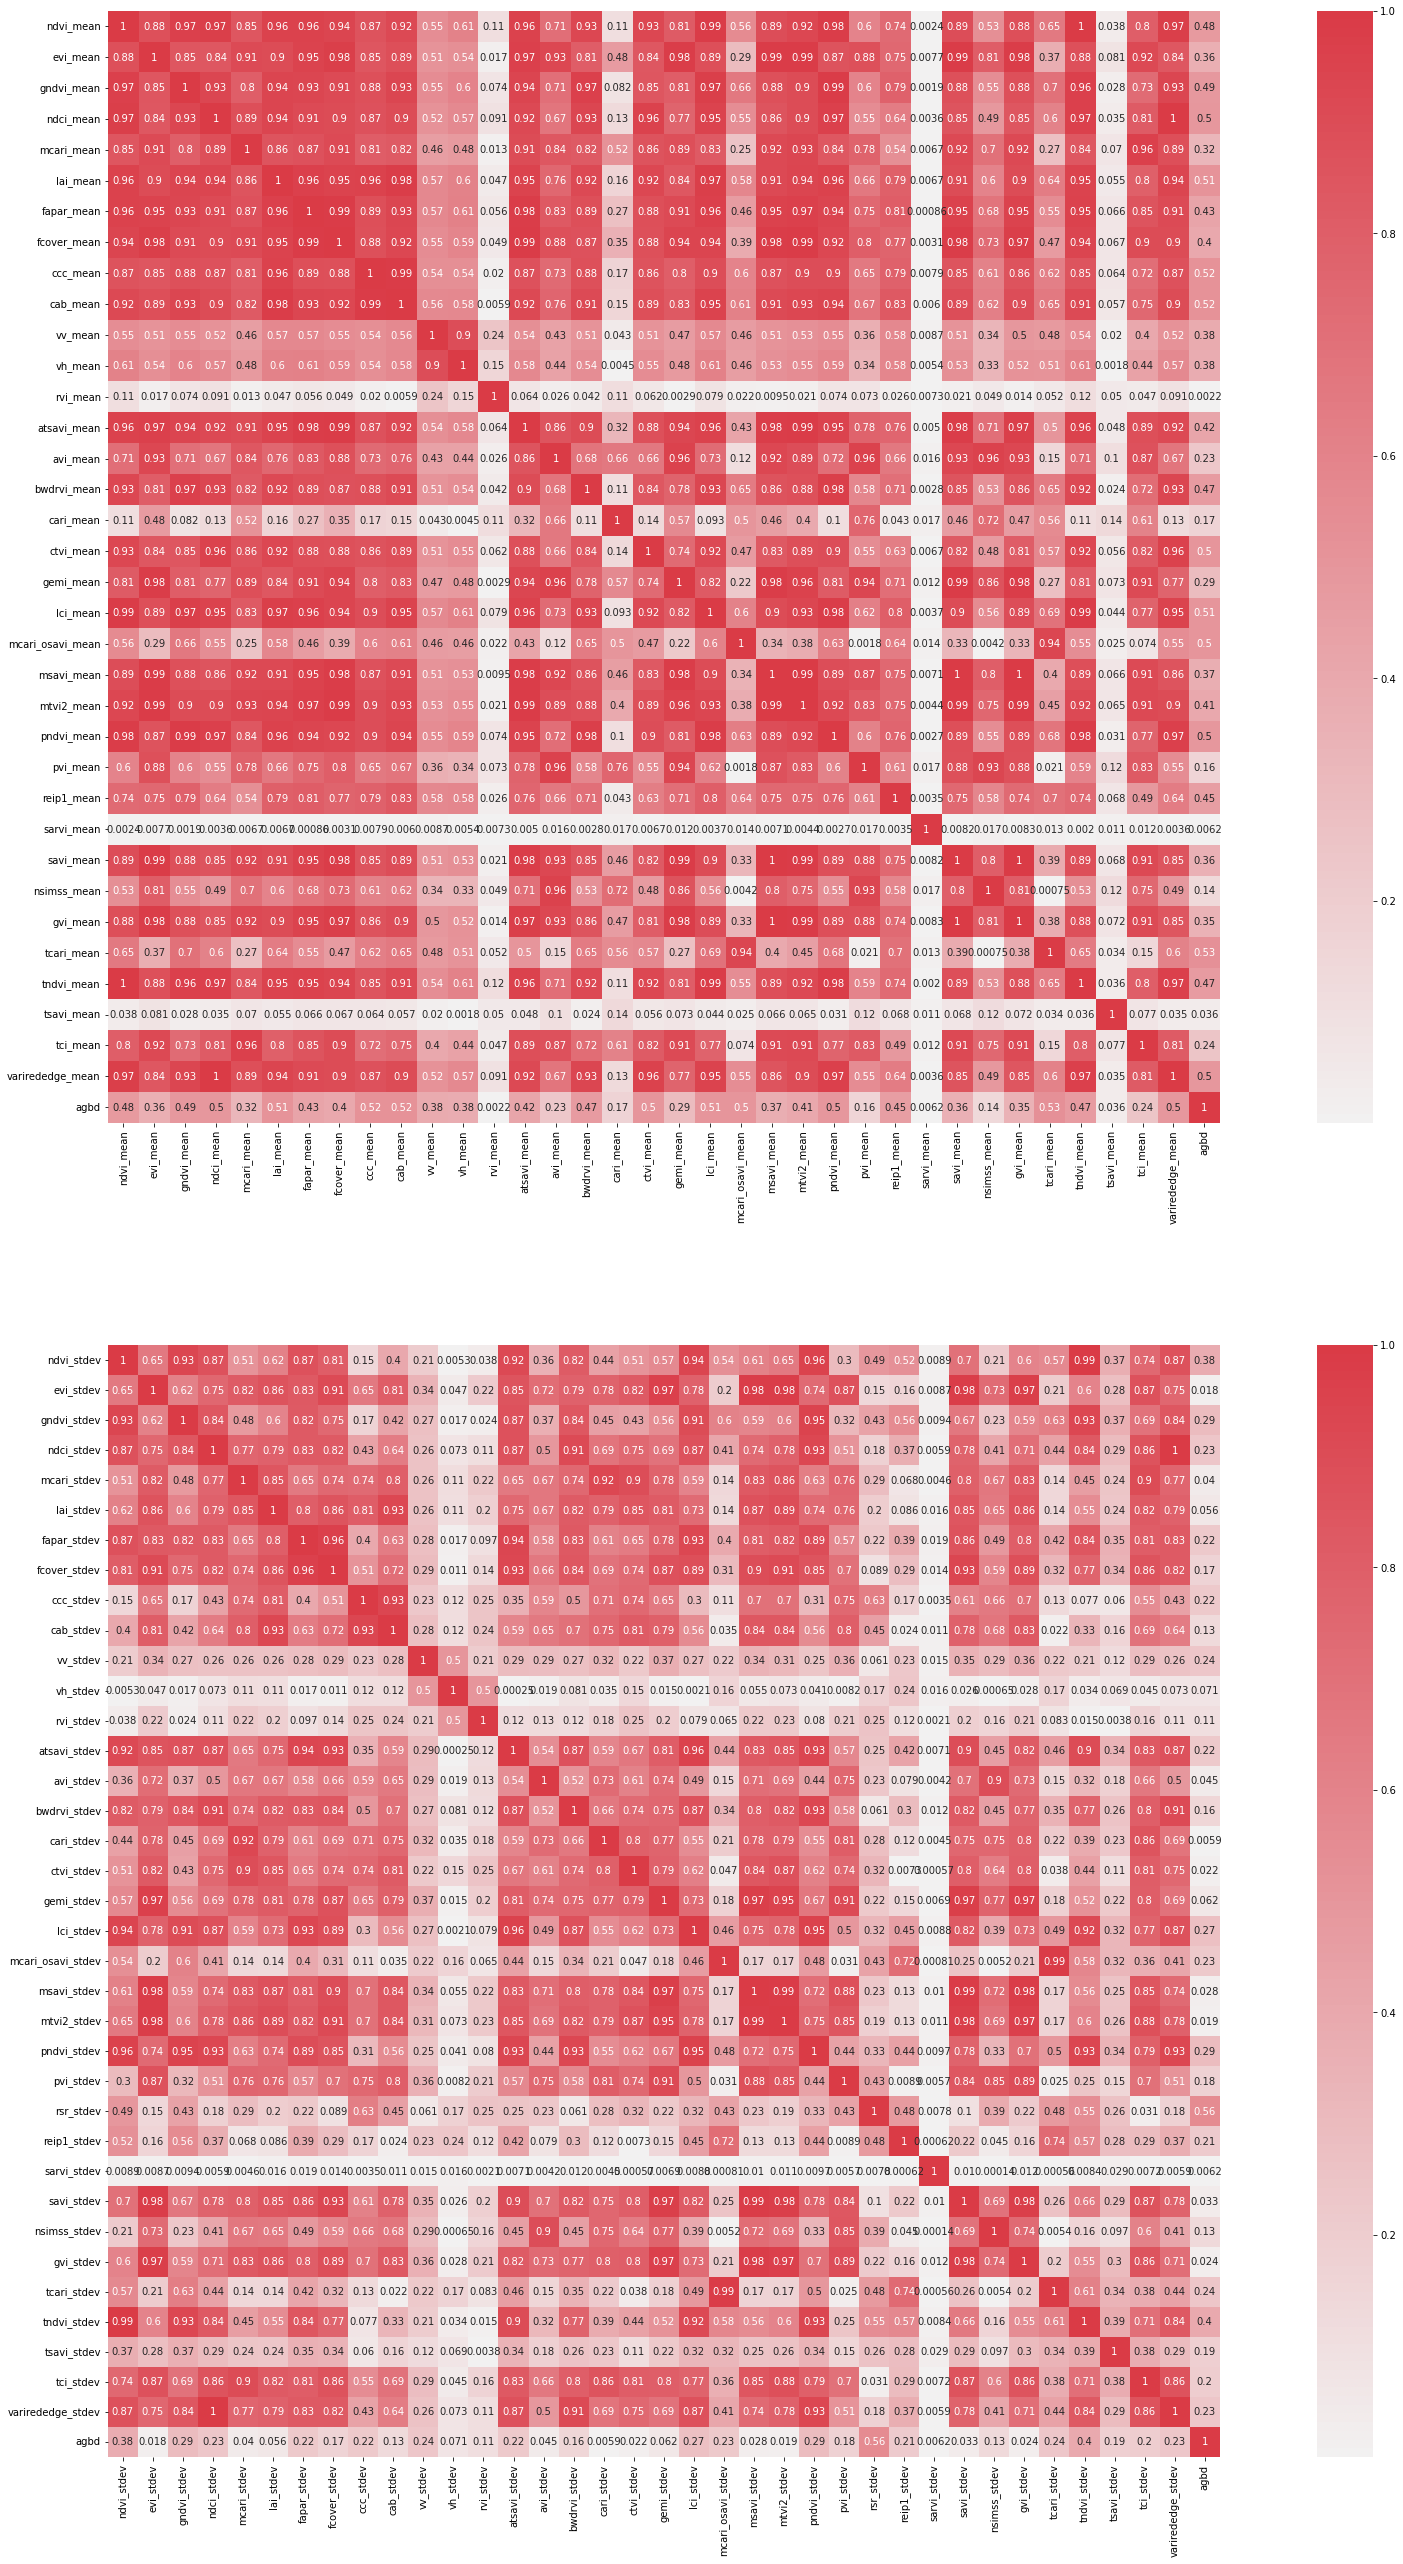

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

def plotCorrelationHeatmap( ax, names, cmap ):

    names.extend( [ 'agbd' ] )
    sns.heatmap( data[ names ].corr().abs(), ax=ax, cmap=cmap, center=0, square=True, annot=True )

# plot correlation matrix
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(35,45) )
cmap = sns.diverging_palette( 500, 10, as_cmap=True )

plotCorrelationHeatmap( axes[ 0 ], [ col for col in data.columns if 'mean' in col ], cmap )
plotCorrelationHeatmap( axes[ 1 ], [ col for col in data.columns if 'stdev' in col ], cmap )

<AxesSubplot:>

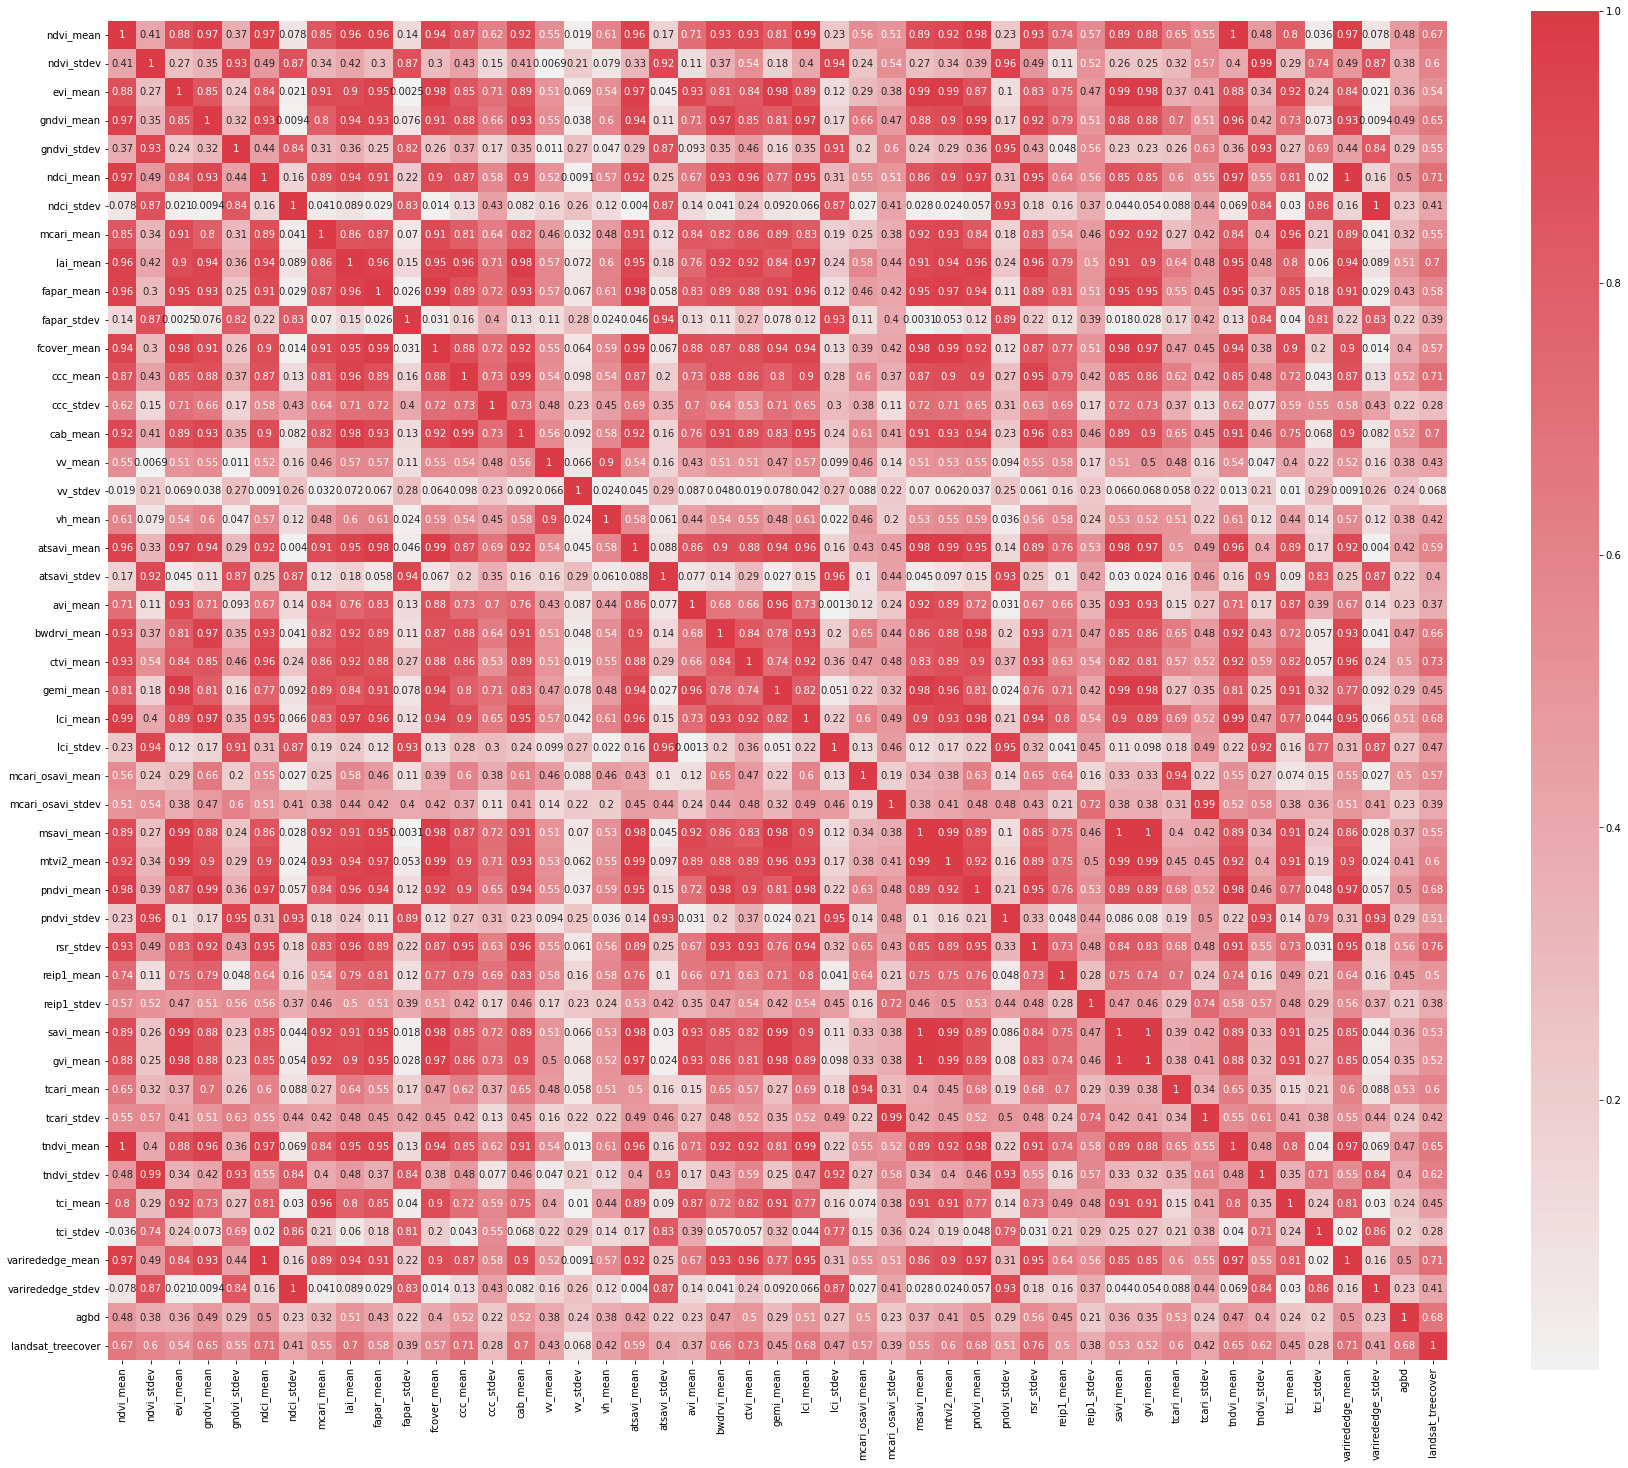

In [16]:
# plot correlation matrix
data = data[ data.columns[ data.corr().abs()[ 'agbd' ] > 0.2 ] ]
plt.figure( figsize=(30,25) )
sns.heatmap( data.corr().abs(), cmap=cmap, center=0, square=True, annot=True )

### Visualise distribution of Sentinel-1 and Sentinel-2 predictor variables

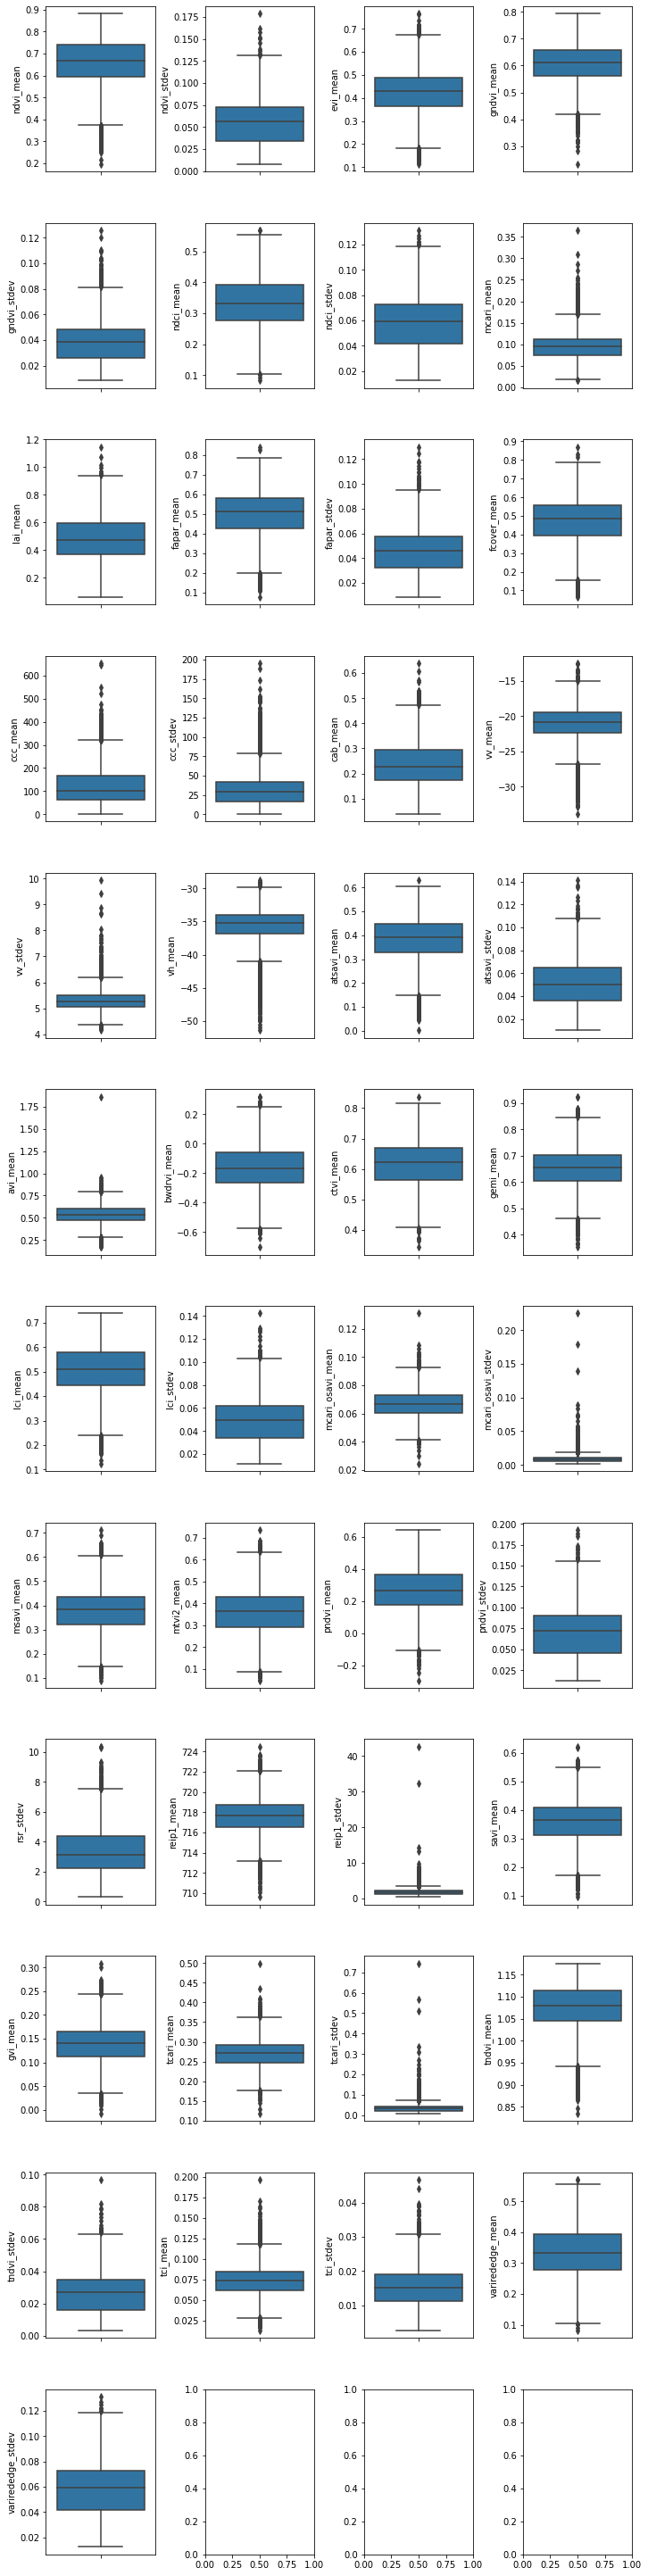

In [17]:
cols = [ col for col in data.columns if 'mean' in col or 'stdev' in col ]

# visualise feature variable distributions using boxplot diagrams
def getBoxPlots( df ):
        
    fig, axs = plt.subplots( ncols=4, nrows=int( len(cols)/4 ) + 1, figsize=(10,40))
    index = 0
    axs= axs.flatten()

    for col in cols:
            sns.boxplot( y=col, data=df, ax=axs[ index ] )
            index += 1

    plt.tight_layout( pad=0.4, w_pad=0.5, h_pad=5.0)
    
getBoxPlots( data )

### Filter outliers by removing records where predictor variable outside 3 stdev range 

In [18]:
# XGBoost regression reslient to outliers 

"""
# implement function to filter out rows where predictor variable outside +- IQR * 1.5 ~ 3 stddevs
def filterOutliers( df, column ):

    # compute inter quantile range
    Q1 = df[ column ].quantile(0.25)
    Q3 = df[ column ].quantile(0.75)
    IQR = Q3 - Q1
    
    # filter values between Q1-1.5IQR and Q3+1.5IQR
    return df.query( f'(@Q1 - 1.5 * @IQR) <= {column} <= (@Q3 + 1.5 * @IQR)')

filtered = filterOutliers ( data, 'ndvi_mean' )
for col in cols:
    filtered = filterOutliers ( filtered, col )

getBoxPlots( filtered )
print ( len ( data ), len( filtered ) )
"""

"\n# implement function to filter out rows where predictor variable outside +- IQR * 1.5 ~ 3 stddevs\ndef filterOutliers( df, column ):\n\n    # compute inter quantile range\n    Q1 = df[ column ].quantile(0.25)\n    Q3 = df[ column ].quantile(0.75)\n    IQR = Q3 - Q1\n    \n    # filter values between Q1-1.5IQR and Q3+1.5IQR\n    return df.query( f'(@Q1 - 1.5 * @IQR) <= {column} <= (@Q3 + 1.5 * @IQR)')\n\nfiltered = filterOutliers ( data, 'ndvi_mean' )\nfor col in cols:\n    filtered = filterOutliers ( filtered, col )\n\ngetBoxPlots( filtered )\nprint ( len ( data ), len( filtered ) )\n"

In [19]:
# take a random subset for regression analysis
# subset = filtered.sample( int( len( filtered ) * 1.0 ) )
subset = data.sample( int( len( data ) * 1.0 ) )
len( subset )

7160

### Train XGBoost Regression model to estimate AGBD from Sentinel vegetation metrics

In [20]:
from sklearn.model_selection import train_test_split

# extract predictor matrix and target vector
target = subset[ 'agbd' ]
features = subset.drop( 'agbd', axis=1 )

# randomly split feature / target sample data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split( features, target, test_size=0.25 )
X_train.head(5)

,ndvi_mean,ndvi_stdev,evi_mean,gndvi_mean,gndvi_stdev,ndci_mean,ndci_stdev,mcari_mean,lai_mean,fapar_mean,...,gvi_mean,tcari_mean,tcari_stdev,tndvi_mean,tndvi_stdev,tci_mean,tci_stdev,varirededge_mean,varirededge_stdev,landsat_treecover
508,0.610347,0.074253,0.382464,0.581185,0.057898,0.244123,0.068639,0.058362,0.361715,0.468464,...,0.122003,0.243937,0.047612,1.053392,0.035665,0.054758,0.017467,0.244123,0.068639,6.0
6777,0.824111,0.027572,0.511335,0.712242,0.030296,0.508364,0.047661,0.152563,0.684564,0.617194,...,0.175208,0.213699,0.022504,1.149956,0.011859,0.094030,0.015207,0.508364,0.047661,90.0
1215,0.743141,0.051503,0.436087,0.673493,0.037750,0.396146,0.064589,0.094834,0.603224,0.573724,...,0.140849,0.216021,0.029560,1.114501,0.023566,0.068991,0.013117,0.396146,0.064589,9.0
569,0.511517,0.089613,0.293345,0.561898,0.050556,0.215091,0.074742,0.048853,0.294837,0.368079,...,0.096286,0.277747,0.053182,1.005078,0.042646,0.041935,0.017148,0.215091,0.074742,9.0
1806,0.705964,0.074673,0.459324,0.625884,0.044910,0.364220,0.079079,0.102440,0.524699,0.538705,...,0.148023,0.262227,0.034439,1.097886,0.034825,0.081863,0.019674,0.364220,0.079079,20.0


In [21]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import xgboost as xgb

# create estimator pipeline
estimators = [ ('standardize', StandardScaler() ), 
               ('mlp', xgb.XGBRegressor( verbosity=1 ) ) ]

pipeline = Pipeline(estimators)

In [22]:
from sklearn.model_selection import GridSearchCV

# grid search space
"""
param_grid = {  'mlp__n_estimators': [400, 700, 1000],
                'mlp__colsample_bytree': [0.7, 0.8],
                'mlp__max_depth': [15,20,25],
                'mlp__reg_alpha': [1.1, 1.2, 1.3],
                'mlp__reg_lambda': [1.1, 1.2, 1.3],
                'mlp__subsample': [0.7, 0.8, 0.9]
}
"""

# define hyperparameter search space
param_grid = {  'mlp__n_estimators': [ 400, 600, 800 ],
                'mlp__learning_rate': [ 0.02 ],
                'mlp__colsample_bytree': [ 0.8 ],
                'mlp__max_depth': [ 10 ],
                'mlp__subsample': [ 0.6, 0.8 ]
}

# brute force cross validation across hyperparameter grid
gs = GridSearchCV(
        pipeline,
        param_grid=param_grid, 
        cv=5, 
        scoring='neg_mean_squared_error',
        verbose=1
    )

In [23]:
# determine optimal hyperparameter configuration against training data
best_model = gs.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


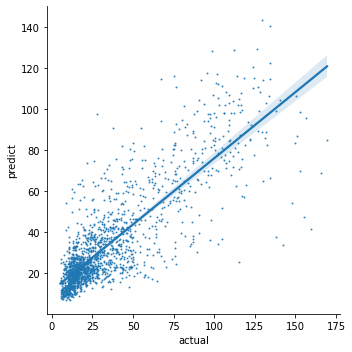

In [24]:
import seaborn as sns

# plot actual vs predicted test agbd values
result = pd.DataFrame( { 'actual' :  y_test.values, 'predict' : best_model.predict( X_test ) } )
sns.lmplot(x='actual',y='predict', data=result, fit_reg=True, scatter_kws={"s": 1 } ) 

In [25]:
# compute r2 between actual and predicted agbd
result[ 'actual' ].corr( result[ 'predict' ] )

0.8297730921980006

In [26]:
print(best_model.best_score_)
print(best_model.best_params_)

-304.2731440038817
{'mlp__colsample_bytree': 0.8, 'mlp__learning_rate': 0.02, 'mlp__max_depth': 10, 'mlp__n_estimators': 600, 'mlp__subsample': 0.6}


<BarContainer object of 46 artists>

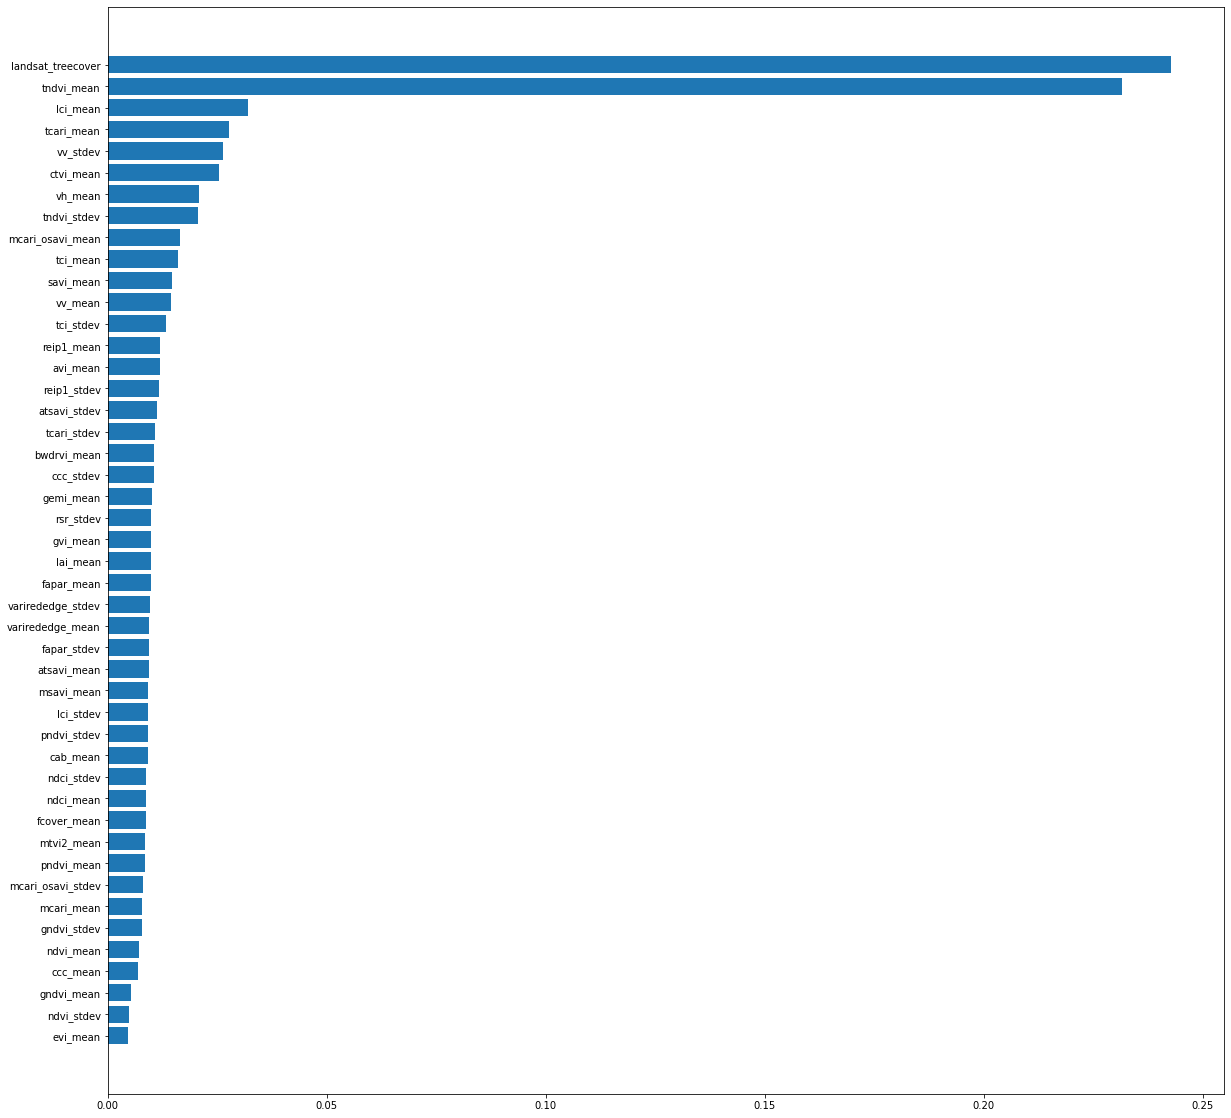

In [27]:
model = best_model.best_estimator_.steps[1][1]
sorted_idx = model.feature_importances_.argsort()

plt.figure( figsize=(20,20) )
plt.barh( best_model.feature_names_in_[sorted_idx], model.feature_importances_[sorted_idx] )